#### Your name:

<pre> Isaac Aktam</pre>

### Collaborators:

<pre> Ashish Gupta, Konrad Korzeniewski</pre>

In [40]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### TensorFlow

Q1. When is a variable initialized? When is it destroyed?

A variable is initialized when you call its initalized, and it is destroyed when its session ends. In distributed TensorFlow, variables live in containers on the cluster, so closing a session will not destroy the variable. To destroy a variable, you need to destroy its container.

Q2. What is the difference between a placeholder and a variable?

They seem similar? Wrong! They are absolutely freaking different, just like apples and fish. Explanation:

 - A "variable" is an operation that holds a valie. If you run the variable, it returns that value. Before you can run it, it needs to initialized. You can change the variable's value (for example by using the assignment operation). It is stateful: the variable keeps the same value upon successive runs of the graph. It is typically used to hold the model parameters but also for other purposes (e.g., to count the global training step).
 
 
 - A "placeholder" does not technically do much: it just holds the information about the type and shape of the tensor they represent, but they have no value. In fact, if you try to evaluate an operation that depends on a placeholder, you must feed TensorFlow the value of a placeholder (using the feed_dict argument) or else you will get an exception. Placeholders are typically used to feed training or test data to TensorFlow during the execution phase. They are also useful to pass a value to an assignment node, to change the value of a variable (e.g., model weights). 

Q3. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

 - "Reverse-model autodiff" (mplemented by TensorFlow) needs to traverse the graph only twice in ordet to compute the gradients of the cost function with regards to any number of variables.
 - On the other hand, "forward-mode" autodiff would need to run once for each variable (so 10 times if we want the gradients with regards to 10 different variables).
 - As for "symbolic differentiation", it would build a different graph to compute the gradients, so it would not traverse the original graph at all (except when building the gradients graph). A highly optimized symbolic differentiation system could potentially run the new gradients graph only once to compute the gradients with regards to all variables, but that new graph may be horribly complex and inefficient compared to the original graph.

Q4. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using name scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [41]:
# First, download the moons dataset using the ScikitLearn's make_moons function.

from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

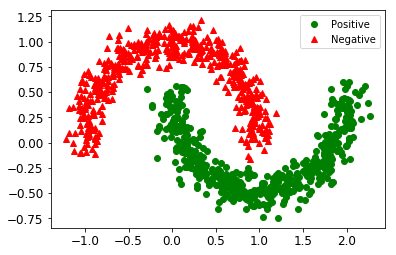

In [42]:
# Let's take a look at the dataset

plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [43]:
# Remember to add the extra bias feature (x_0 = 1) to every instance. For this, we just need to add a 
# column full of 1s on the left of the input matrix X:

X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [44]:
# Let's check

X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [45]:
# Let's reshape y_moons to make it a column vector

y_moons_column_vector = y_moons.reshape(-1, 1)

In [46]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size] # Include the first 800 instances
X_test = X_moons_with_bias[-test_size:] # Include the remaining 200 instances
y_train = y_moons_column_vector[:-test_size] # Include the first 800 instances
y_test = y_moons_column_vector[-test_size:] # Include the remaining 200 instances

Ok, now let's create a small function to generate training batches. In this implementation we will just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact it will generally cover only about two thirds of the instances). However, in practice this is not an issue and it simplifies the code:

In [47]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

Let's look at a small batch:

In [48]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  0.05114641,  0.25842105],
       [ 1.        ,  0.35697595,  1.00820789],
       [ 1.        ,  0.24998693, -0.17585236],
       [ 1.        ,  0.88414476,  0.43423354],
       [ 1.        , -0.03703635,  0.88578278]])

In [49]:
y_batch

array([[1],
       [0],
       [1],
       [0],
       [0]])

Great! Now that the data is ready to be fed to the model, we need to build that model.

First let's reset the default graph.

In [50]:
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

import tensorflow as tf

reset_graph()

The moons dataset has two input features, since each instance is a point on a plane (i.e., 2-Dimensional):

In [51]:
n_inputs = 2

Now let's build the Logistic Regression model. As we saw in chapter 4, this model first computes a weighted sum of the inputs (just like the Linear Regression model), and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:

$\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$

Recall that $\mathbf{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, \dots, \theta_n$. The input vector $\mathbf{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, \dots, x_n$.

Since we want to be able to make predictions for multiple instances at a time, we will use an input matrix $\mathbf{X}$ rather than a single input vector. The $i^{th}$ row will contain the transpose of the $i^{th}$ input vector $(\mathbf{x}^{(i)})^T$. It is then possible to estimate the probability that each instance belongs to the positive class using the following equation:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

That's all we need to build the model:

In [52]:
X = tf.placeholder(tf.float32, shape = (None, n_inputs + 1), name = "X")
y = tf.placeholder(tf.float32, shape = (None, 1), name = "y")

theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed = 42), name = "theta")
logits = tf.matmul(X, theta, name = "logits")
y_proba = tf.sigmoid(logits)

As we saw in chapter 4, the log loss is a good cost function to use for Logistic Regression:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

In [53]:
loss = tf.losses.log_loss(y, y_proba) # uses epsilon = 1e-7 by default

In [54]:
# Well, let's start optimizing

learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [55]:
n_epochs = 1000
batch_size = 200

n_batches = int(np.ceil(m / batch_size))

In [56]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
        loss_val = loss.eval({X : X_test, y : y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            
    y_proba_val = y_proba.eval(feed_dict = {X : X_batch, y : y_batch})

Epoch: 0 	Loss: 0.8196367
Epoch: 100 	Loss: 0.47140634
Epoch: 200 	Loss: 0.39675096
Epoch: 300 	Loss: 0.3631371
Epoch: 400 	Loss: 0.34379813
Epoch: 500 	Loss: 0.33055198
Epoch: 600 	Loss: 0.32100132
Epoch: 700 	Loss: 0.31364074
Epoch: 800 	Loss: 0.3079226
Epoch: 900 	Loss: 0.30325115


For each instance in the test set, y_proba_val contains the estimated probability that it belongs to the positive class, according to the model. For example, here are the first 5 estimated probabilities:

In [57]:
y_proba_val[:5]

array([[0.03761655],
       [0.8658452 ],
       [0.07082568],
       [0.9615447 ],
       [0.41433707]], dtype=float32)

To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [58]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[False],
       [ True],
       [False],
       [ True],
       [False]])

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision). See chapter 3 for more details.

Let's compute the model's precision and recall:

In [59]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.5052631578947369

In [60]:
recall_score(y_test, y_pred)

0.48484848484848486

Let's plot these predictions to see what they look like:

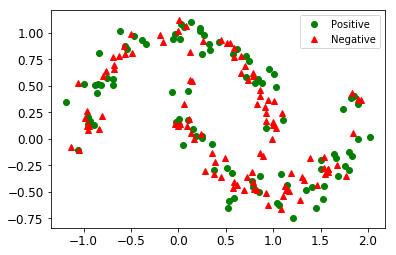

In [61]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

This is terrible! But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).

Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using nice scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model.

In [234]:
# Let's reset the default graph

reset_graph()

In [235]:
X_train_poly = np.c_[X_train, X_train[:, 1] ** 2, X_train[:, 2] ** 2, X_train[:, 1] ** 3, X_train[:, 2] ** 3]

X_test_poly = np.c_[X_test, X_test[:, 1] ** 2, X_test[:, 2] ** 2, X_test[:, 1] ** 3, X_test[:, 2] ** 3]

In [236]:
##########################################################################################
### Define the graph within a logistic_regression() function that can be reused easily ###
##########################################################################################

# The idea is to create some form of a "logistic_regression()" function that can be used repeatedly. This 
# makes code cleaner and easier to run whenever we want it to.

# First, let's understand what's going when we work with any model in the TensorFlow and what it requires
# - We need variables. In the case of log_reg, we need, X, y, and theta
# - We need the loss function and optimizer to initiate training
# - We need to initialize the global variables
# - We need to save the trained results
# - We need the return function
# Therefore: variables, loss, initializer, save, return

def logistic_banana(X, y, learning_rate, seed = 42):
    n_inputs_including_bias = int(X.get_shape()[1]) # Need to get the number of columns to generate the number
                                                    # of rows for the theta
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=42), name="theta")
            logits = tf.matmul(X, theta, name = "logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope = "loss") # uses epsilon = 1e-7 by default
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a function to get the name of the log directory to save the summaries for Tensorboard.

In [237]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Next:
 - Create the graph, using the logistic_regression() function. 
 - We will also create the FileWriter to save the summaries to the log directory for TensorBoard.

In [238]:
n_inputs = 2 + 4
logdir = log_dir("logreg")
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = (None, n_inputs + 1), name = "X")
y = tf.placeholder(tf.float32, shape = (None, 1), name = "y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_banana(X, y, learning_rate)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Training time. We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example, we will just save the epoch number to a separate file.

In [239]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
            sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict = {X : X_test_poly, y : y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict = {X : X_test_poly, y : y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122364
Epoch: 1000 	Loss: 0.1190321
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.074375816
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026794
Epoch: 4500 	Loss: 0.054562975
Epoch: 5000 	Loss: 0.051708292
Epoch: 5500 	Loss: 0.049237743
Epoch: 6000 	Loss: 0.047167286
Epoch: 6500 	Loss: 0.04537664
Epoch: 7000 	Loss: 0.043818746
Epoch: 7500 	Loss: 0.04237422
Epoch: 8000 	Loss: 0.041089162
Epoch: 8500 	Loss: 0.039970912
Epoch: 9000 	Loss: 0.038920246
Epoch: 9500 	Loss: 0.038010743
Epoch: 10000 	Loss: 0.037155695


Once again, we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5

In [68]:
y_pred = (y_proba_val >= 0.5)

In [69]:
precision_score(y_test, y_pred)

0.9797979797979798

In [70]:
recall_score(y_test, y_pred)

0.9797979797979798

In [71]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.98

In [72]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[99,  2],
       [ 2, 97]])

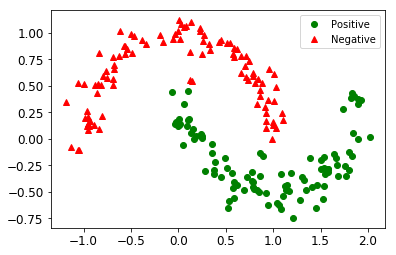

In [73]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label = "Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label = "Negative")
plt.legend()
plt.show()

Holy banana! This is so much better! Adding extra features helped out a lot.

Now, let's play with the hyperparameters (e.g., batch_size and learning_rate) and run training again and again, comparing the learning curves. This process can be automated by implementing the grid search or randomized search. 

In [74]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state = search_iteration)
    
    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print(" logdir:", logdir)
    print(" batch_size", batch_size)
    print(" learning_rate", learning_rate)
    print(" training", end = "")
    
    reset_graph()
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs + 1), name = "X")
    y = tf.placeholder(tf.float32, shape = (None, 1), name = "y")
    
    y_proba, loss, training_op, loss_summary, init, saver = logistic_banana(X, y, learning_rate = learning_rate)
    
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))
    
    final_model_path = "./my_logreg_model_%d" % search_iteration
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
                sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict = {X : X_test_poly, y : y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end = "")
                
        saver.save(sess, final_model_path)
        
        print()
        y_proba_val = y_proba.eval(feed_dict = {X: X_test_poly, y : y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print(" precision:", precision_score(y_test, y_pred))
        print(" recall:", recall_score(y_test, y_pred))

Iteration 0
 logdir: tf_logs/logreg-run-20180318225942/
 batch_size 54
 learning_rate 0.004430375245218265
 training.....................
 precision: 0.9797979797979798
 recall: 0.9797979797979798
Iteration 1
 logdir: tf_logs/logreg-run-20180318230056/
 batch_size 22
 learning_rate 0.0017826497151386947
 training.....................
 precision: 0.9797979797979798
 recall: 0.9797979797979798
Iteration 2
 logdir: tf_logs/logreg-run-20180318230339/
 batch_size 74
 learning_rate 0.00203228544324115
 training.....................
 precision: 0.9696969696969697
 recall: 0.9696969696969697
Iteration 3
 logdir: tf_logs/logreg-run-20180318230436/
 batch_size 58
 learning_rate 0.004491523825137997
 training.....................
 precision: 0.9797979797979798
 recall: 0.9797979797979798
Iteration 4
 logdir: tf_logs/logreg-run-20180318230548/
 batch_size 61
 learning_rate 0.07963234721775589
 training.....................
 precision: 0.9801980198019802
 recall: 1.0
Iteration 5
 logdir: tf_logs/lo

So, the best result is:

Iteration 4

 logdir: tf_logs/logreg-run-20180318075632/
 
 batch_size 75
 
 learning_rate 0.07963234721775589
 
 training.....................
 
 precision: 0.9801980198019802
 
 recall: 1.0

Q5. Similar to the linear regression implementation in class, write a lasso regression implementation. Use the same dataset, and choose a value for the penalty $\alpha$:

Using a Saver at regular intervals during training, and save the final model at the end of training.

Restore the last checkpoint upon startup if training was interrupted.

Define the graph using name scopes so the graph looks good in TensorBoard.

Add summaries to visualize the learning curves in TensorBoard.

Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [301]:
# Let's reset the default graph

reset_graph()

In [361]:
X_train_poly = np.c_[X_train, X_train[:, 1] ** 2, X_train[:, 2] ** 2, X_train[:, 1] ** 3, X_train[:, 2] ** 3]

X_test_poly = np.c_[X_test, X_test[:, 1] ** 2, X_test[:, 2] ** 2, X_test[:, 1] ** 3, X_test[:, 2] ** 3]

In [389]:
def lasso_reg(X, y, learning_rate, lasso_param, seed = 42):
    n_inputs_including_bias = int(X.get_shape()[1]) # Need to get the number of columns to generate the number
                                                    # of rows for the theta
    lasso_param = tf.constant(lasso_param)
    
    with tf.name_scope("lasso_regression"):
        with tf.name_scope("model"):
            new_theta = tf.Variable(tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=42), 
                                    name="new_theta")
            y_pred = tf.matmul(X, new_theta, name="predictions")
        with tf.name_scope("train"):
            #We add the loss function, which is a modified continuous heavyside step function.
            
            heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-100., tf.subtract(new_theta, lasso_param)))))
            regularization_param = tf.multiply(heavyside_step, 99.)
            loss = tf.add(tf.reduce_mean(tf.square(y - y_pred)), regularization_param) 
            
            #heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-100., 
                                                                          #tf.subtract(new_theta, lasso_param)))))
            #regularization_param = tf.multiply(heavyside_step, 99.)
            #loss = tf.add(tf.reduce_mean(tf.square(y - y_pred)), regularization_param)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            # tf.summary.scalar(value.op.name, value)
            #loss_summary = tf.summary.scalar('lasso_loss', loss) # THE ORIGINAL. DO NOT DELETE!
            #loss_summary = tf.summary.scalar('lasso_loss', tf.reduce_mean(loss)) # DO NOT DELETE!
            loss = tf.reduce_mean(loss)
            loss_summary = tf.summary.scalar('lasso_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver(max_to_keep=None)
    return y_pred, loss, training_op, loss_summary, init, saver

In [390]:
from datetime import datetime

def lasso_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [413]:
n_inputs = 2 + 4
lassodir = lasso_dir("lassoreg")

learning_rate = 0.000001
lasso_param = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_pred, loss, training_op, loss_summary, init, saver = lasso_reg(X, y, learning_rate, lasso_param)

file_writer = tf.summary.FileWriter(lassodir, tf.get_default_graph())

In [414]:
#Code here

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

new_checkpoint_path = "/tmp/lassoreg_model.ckpt"
new_checkpoint_epoch_path = new_checkpoint_path + ".epoch"
final_model_path = "./lassoreg_model"

with tf.Session() as sess:
    if os.path.isfile(new_checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(new_checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, new_checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
            sess.run(training_op, feed_dict = {X:X_batch, y:y_batch})
        # tf.scalar_summary([loss.op.name], loss)
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict = {X:X_test_poly, y:y_test}) # ORIGINAL
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_pred_val = y_pred.eval(feed_dict = {X:X_test_poly, y:y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 43.72359
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 500 	Loss: 43.083424
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1000 	Loss: 43.05899
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1500 	Loss: 43.01138
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 2000 	Loss: 42.97468
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 2500 	Loss: 42.948708
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 3000 	Loss: 42.92331
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 3500 	Loss: 28.739138
INFO:tensorflow:/tmp/my_logreg_model.ckpt is not in all_model_checkpoint_path

In [445]:
# IT IS TWEAKING TIME!

from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.000001, 0.0001).rvs(random_state = search_iteration)
    
    n_inputs = 2 + 4
    lassodir = lasso_dir("lassoreg")
    
    print("Iteration", search_iteration)
    print(" logdir:", logdir)
    print(" batch_size", batch_size)
    print(" learning_rate", learning_rate)
    print(" training", end = "")
    
    reset_graph()
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs + 1), name = "X")
    y = tf.placeholder(tf.float32, shape = (None, 1), name = "y")
    
    y_pred, loss, training_op, loss_summary, init, saver = lasso_reg(X, y, learning_rate, lasso_param)
    
    file_writer = tf.summary.FileWriter(lassodir, tf.get_default_graph())
    
    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))
    
    final_model_path = "./lassoreg_model_%d" % search_iteration
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_poly, y_train, batch_size)
                sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict = {X : X_test_poly, y : y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end = "")
                
        saver.save(sess, final_model_path)
        
        # WORK WITH THINGS BELOW
        
        print()
        y_pred_val = y_pred.eval(feed_dict = {X:X_test_poly, y:y_test})
        y_pred = (y_pred_val >= -1.0)
        
        print(" precision:", precision_score(y_test, y_pred))
        print(" recall:", recall_score(y_test, y_pred))


Iteration 0
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 61
 learning_rate 1.2520653814999462e-05
 training.....................INFO:tensorflow:./lassoreg_model_0 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.495
 recall: 1.0
Iteration 1
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 92
 learning_rate 6.82407842709883e-06
 training.....................INFO:tensorflow:./lassoreg_model_1 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.495
 recall: 1.0
Iteration 2
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 74
 learning_rate 7.447144904083069e-06
 training.....................INFO:tensorflow:./lassoreg_model_2 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.495
 recall: 1.0
Iteration 3
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 58
 learning_rate 1.263559813738166e-05
 training.....................INFO:tensorflow:./lassoreg_model_3 is not in all_model_checkpoint_paths. 

/home/isaac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater_equal
/home/isaac/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


....................INFO:tensorflow:./lassoreg_model_5 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.495
 recall: 1.0
Iteration 6
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 74
 learning_rate 6.105486887627989e-05
 training.....................INFO:tensorflow:./lassoreg_model_6 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.0
 recall: 0.0
Iteration 7
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 58
 learning_rate 1.4210736239935736e-06
 training.....................INFO:tensorflow:./lassoreg_model_7 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.495
 recall: 1.0
Iteration 8
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 61
 learning_rate 5.5828865879781986e-05
 training.....................INFO:tensorflow:./lassoreg_model_8 is not in all_model_checkpoint_paths. Manually adding it.

 precision: 0.0
 recall: 0.0
Iteration 9
 logdir: tf_logs/logreg-run-20180319025308/
 batch_size 

From the above, we can see that the best result is the following:

precision: 0.495

 recall: 1.0
 
Iteration 1

 logdir: tf_logs/logreg-run-20180319025308/
 
 batch_size 92
 
 learning_rate 6.82407842709883e-06
 
 training.....................INFO:tensorflow:./lassoreg_model_1 is not in all_model_checkpoint_paths. Manually adding it.

So, one thing that stands out in regards to the learning curves between the LogReg and LassoReg is that LogReg has a smooth decreasing curve (similar to 1/x where x >0) and LassoReg looks like a step function.